In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# Ensemble methods

The goal of **ensemble methods** is to combine the predictions of
several base estimators built with a given learning algorithm in order
to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:

-   In **averaging methods**, the driving principle is to build several
    estimators independently and then to average their predictions. On
    average, the combined estimator is usually better than any of the
    single base estimator because its variance is reduced.

    **Examples:** `Bagging methods `,
    `Forests of randomized trees` \...

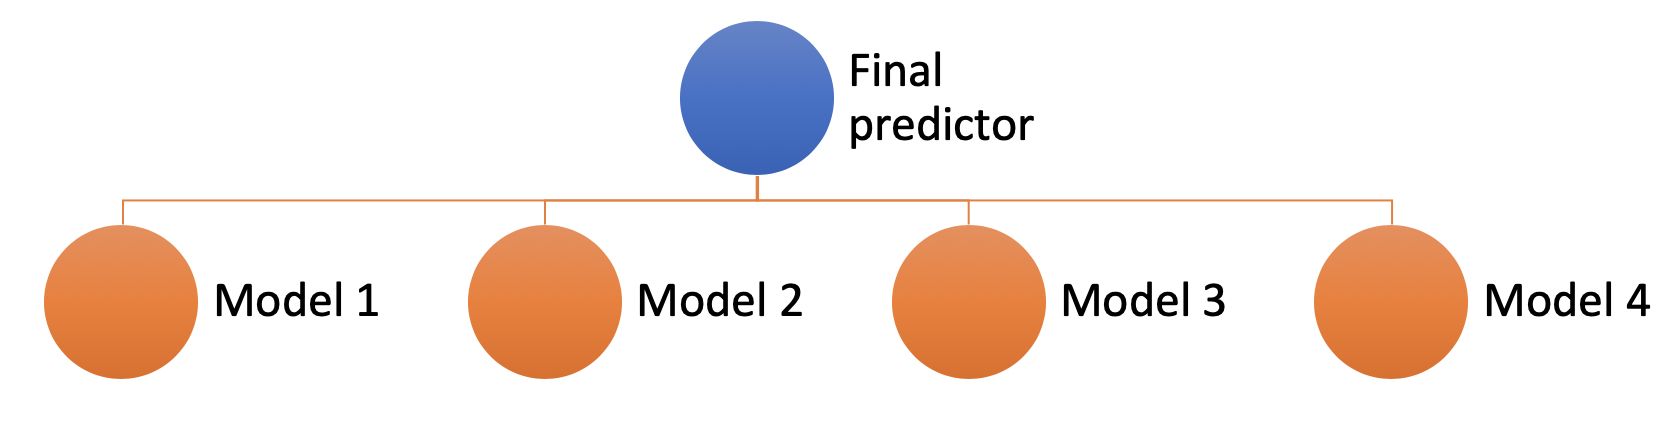

-   By contrast, in **boosting methods**, base estimators are built
    sequentially and one tries to reduce the bias of the combined
    estimator. The motivation is to combine several weak models to
    produce a powerful ensemble.

    **Examples:** `AdaBoost`,
    `Gradient Tree Boosting`, \...
    
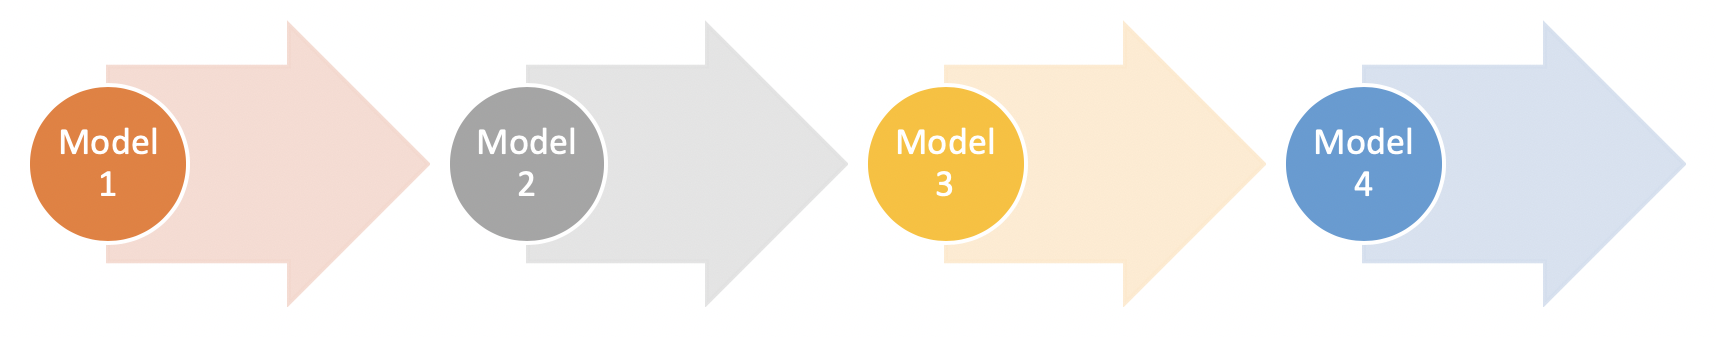

# Bagging meta-estimator

In ensemble algorithms, bagging methods form a class of algorithms which
build several instances of a black-box estimator on random subsets of
the original training set and then aggregate their individual
predictions to form a final prediction. These methods are used as a way
to reduce the variance of a base estimator (e.g., a decision tree), by
introducing randomization into its construction procedure and then
making an ensemble out of it. In many cases, bagging methods constitute
a very simple way to improve with respect to a single model, without
making it necessary to adapt the underlying base algorithm. As they
provide a way to reduce overfitting, bagging methods work best with
strong and complex models (e.g., fully developed decision trees), in
contrast with boosting methods which usually work best with weak models
(e.g., shallow decision trees).

Bagging methods come in many flavours but mostly differ from each other
by the way they draw random subsets of the training set:

> -   *Pasting* - When random subsets of the dataset are drawn as random subsets of
>     the sample.
> -   *Bagging* - When samples are drawn with replacement.
> -   *Random Subspaces* - When random subsets of the dataset are drawn as random subsets of the features.
> -   *Random Patches* - Finally, when base estimators are built on subsets of both samples and features.

In scikit-learn, bagging methods are offered as a unified
`BaggingClassifier` meta-estimator
(resp. `BaggingRegressor`), taking as
input a user-specified base estimator along with parameters specifying
the strategy to draw random subsets. In particular, `max_samples` and
`max_features` control the size of the subsets (in terms of samples and
features), while `bootstrap` and `bootstrap_features` control whether
samples and features are drawn with or without replacement. When using a
subset of the available samples the generalization accuracy can be
estimated with the out-of-bag samples by setting `oob_score=True`. As an
example, the snippet below illustrates how to instantiate a bagging
ensemble of `KNeighborsClassifier` base
estimators, each built on random subsets of 50% of the samples and 50%
of the features.

In [2]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

# Voting Classifier

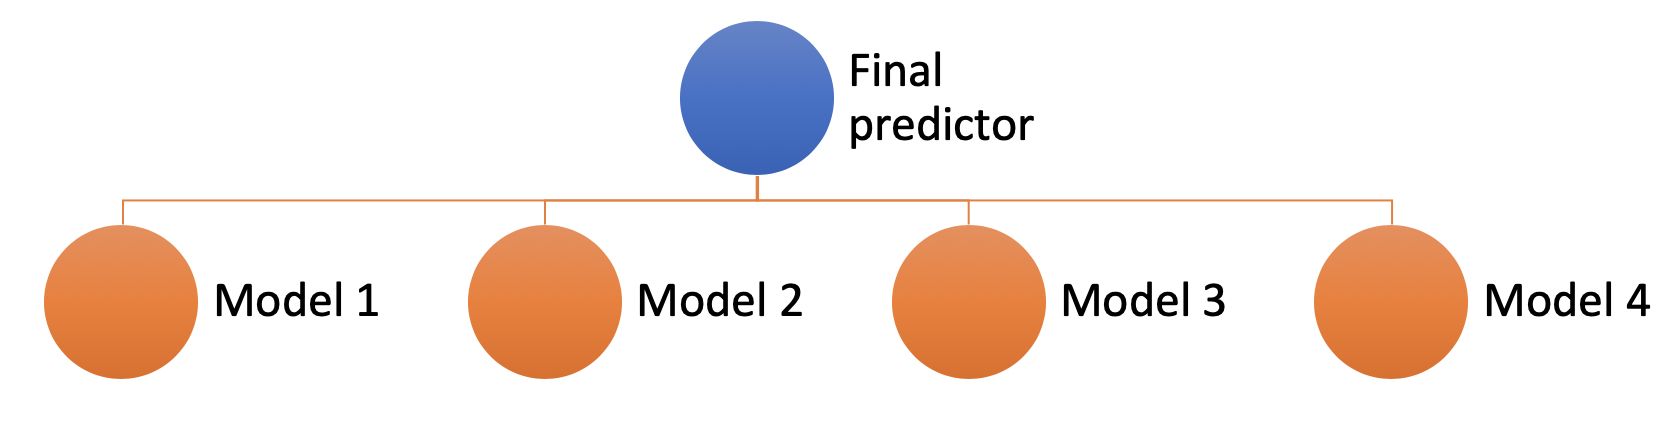

The idea behind the `VotingClassifier`
is to combine conceptually different machine learning classifiers and
use a majority vote or the average predicted probabilities (soft vote)
to predict the class labels. Such a classifier can be useful for a set
of equally well performing model in order to balance out their
individual weaknesses.

## Majority Class Labels (Majority/Hard Voting)

In majority voting, the predicted class label for a particular sample is
the class label that represents the majority (mode) of the class labels
predicted by each individual classifier.

E.g., if the prediction for a given sample is

-   classifier 1 -\> class 1
-   classifier 2 -\> class 1
-   classifier 3 -\> class 2

the VotingClassifier (with `voting='hard'`) would classify the sample as
"class 1" based on the majority class label.

In the cases of a tie, the `VotingClassifier` will select the class based on the ascending sort order.
E.g., in the following scenario

-   classifier 1 -\> class 2
-   classifier 2 -\> class 1

the class label 1 will be assigned to the sample.

Usage
-----

The following example shows how to fit the majority rule classifier:


In [3]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

clf1 = LogisticRegression(random_state=1, solver='lbfgs', multi_class='auto')
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.95 (+/- 0.04) [Logistic Regression]
Accuracy: 0.94 (+/- 0.04) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]
Accuracy: 0.95 (+/- 0.04) [Ensemble]


## Weighted Average Probabilities (Soft Voting)

In contrast to majority voting (hard voting), soft voting returns the
class label as argmax of the sum of predicted probabilities.

Specific weights can be assigned to each classifier via the `weights`
parameter. When weights are provided, the predicted class probabilities
for each classifier are collected, multiplied by the classifier weight,
and averaged. The final class label is then derived from the class label
with the highest average probability.

To illustrate this with a simple example, let\'s assume we have 3
classifiers and a 3-class classification problems where we assign equal
weights to all classifiers: w1=1, w2=1, w3=1.

The weighted average probabilities for a sample would then be calculated
as follows:

  |classifier         |class 1     |class 2     |class 3     |
  |------------------ |----------- |----------- |----------- |
  |classifier 1       |w1 \* 0.2   |w1 \* 0.5   |w1 \* 0.3   |
  |classifier 2       |w2 \* 0.6   |w2 \* 0.3   |w2 \* 0.1   |
  |classifier 3       |w3 \* 0.3   |w3 \* 0.4   |w3 \* 0.3   |
  |weighted average   |0.37        |0.4         |0.23        |

Here, the predicted class label is 2, since it has the highest average
probability.

The following example illustrates how the decision regions may change
when a soft `VotingClassifier` is used
based on an linear Support Vector Machine, a Decision Tree, and a
K-nearest neighbor classifier:


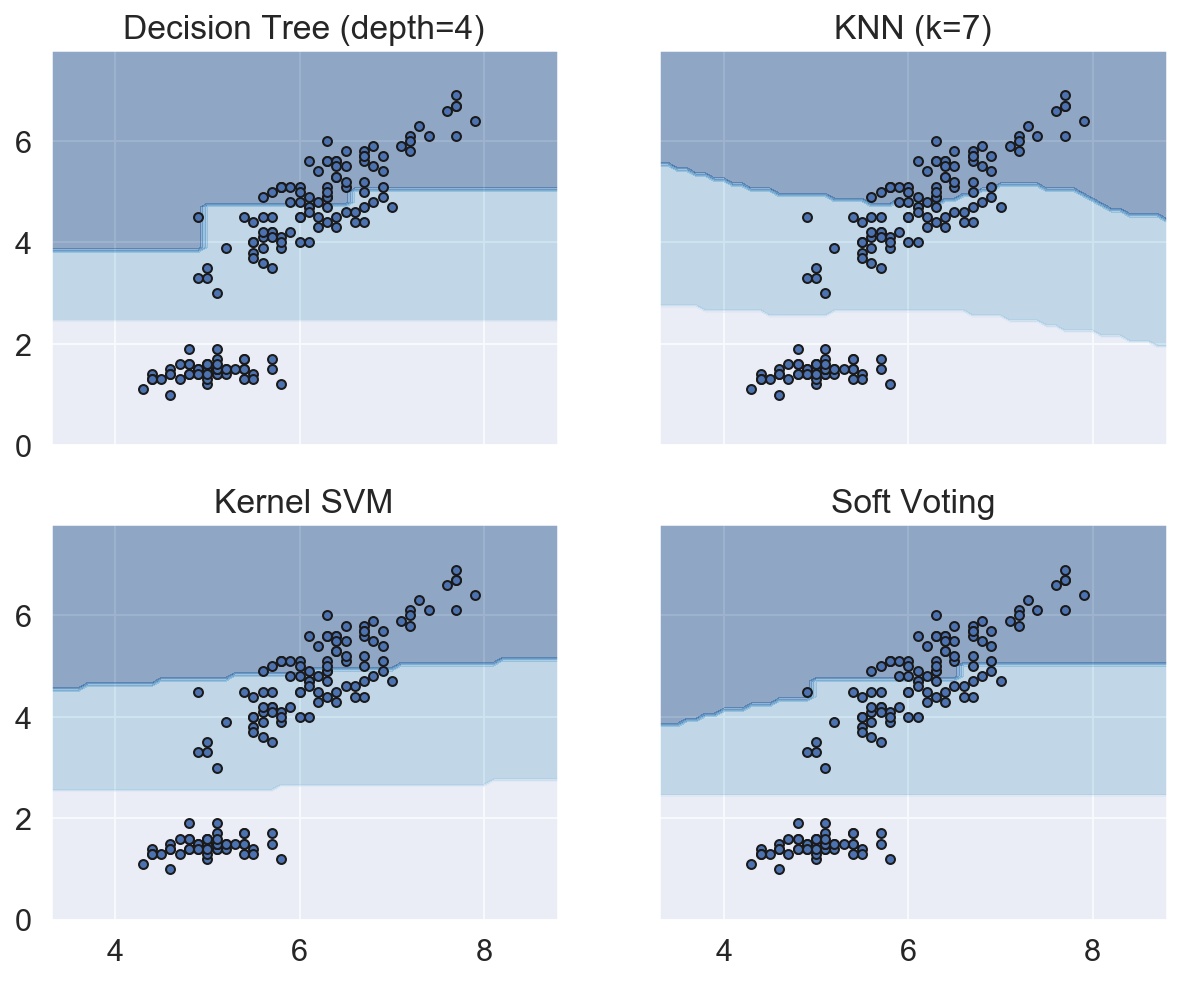

In [25]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(gamma=.1, kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))
cmap = plt.cm.Blues

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], cmap=cmap,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

## Voting Regressor

The idea behind the `VotingRegressor` is
to combine conceptually different machine learning regressors and return
the average predicted values. Such a regressor can be useful for a set
of equally well performing models in order to balance out their
individual weaknesses.

### Usage

The following example shows how to fit the VotingRegressor:

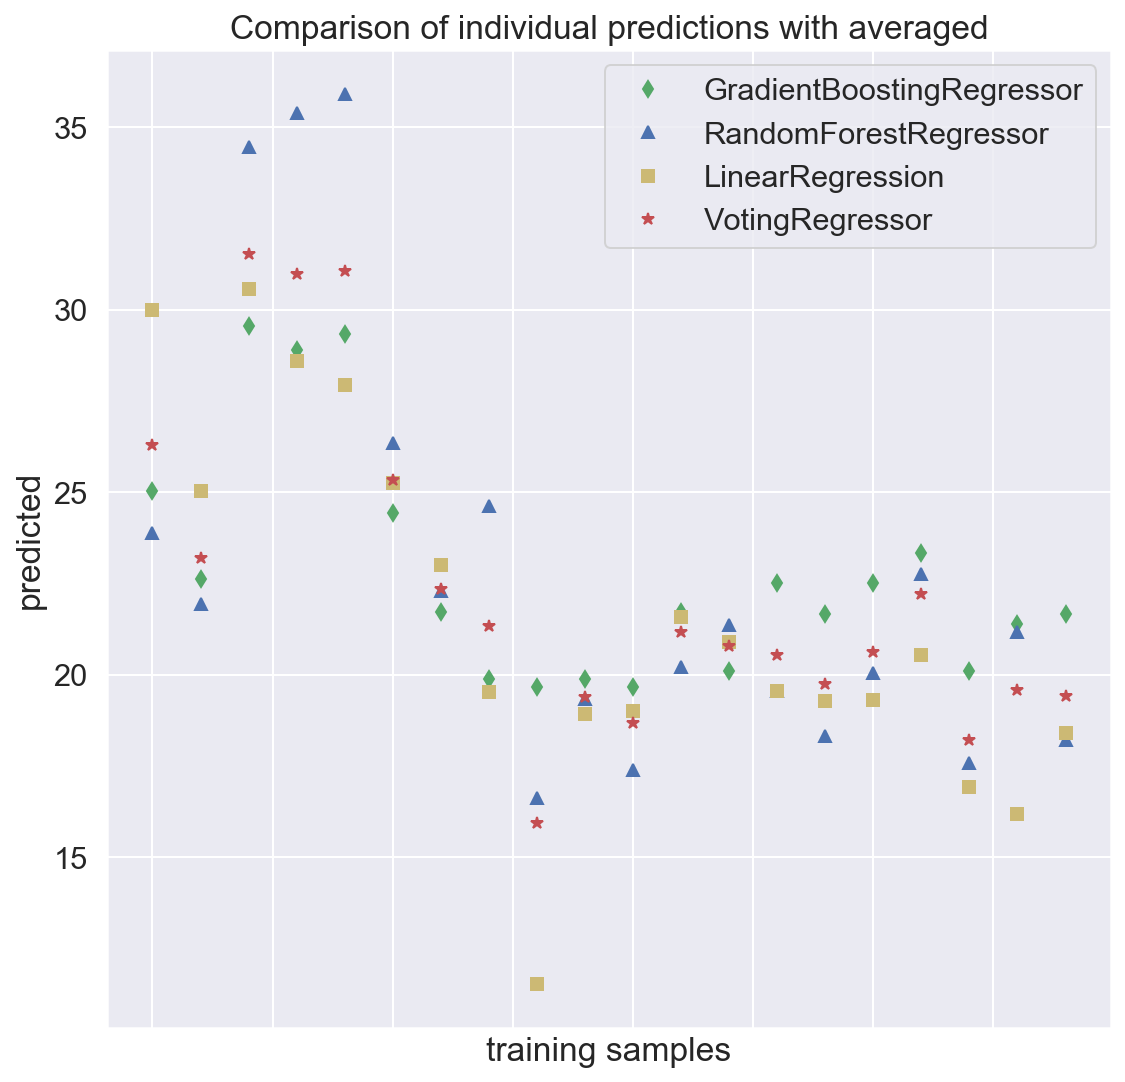

In [5]:
from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

# Loading some example data
X, y = datasets.load_boston(return_X_y=True)

# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
reg3 = LinearRegression()
ereg = VotingRegressor([('gb', reg1), ('rf', reg2), ('lr', reg3)])
reg1.fit(X, y)
reg2.fit(X, y)
reg3.fit(X, y)
ereg.fit(X, y)

xt = X[:20]

plt.figure()
plt.plot(reg1.predict(xt), 'gd', label='GradientBoostingRegressor')
plt.plot(reg2.predict(xt), 'b^', label='RandomForestRegressor')
plt.plot(reg3.predict(xt), 'ys', label='LinearRegression')
plt.plot(ereg.predict(xt), 'r*', label='VotingRegressor')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.show()

# Forests of randomized trees 

The `sklearn.ensemble` module includes two
averaging algorithms based on randomized
`decision trees`: the RandomForest
algorithm and the Extra-Trees method. Both algorithms are
perturb-and-combine techniques specifically designed for
trees. This means a diverse set of classifiers is created by introducing
randomness in the classifier construction. The prediction of the
ensemble is given as the averaged prediction of the individual
classifiers.

As other classifiers, forest classifiers have to be fitted with two
arrays: a sparse or dense array X of size `[n_samples, n_features]`
holding the training samples, and an array Y of size `[n_samples]`
holding the target values (class labels) for the training samples:

In [6]:
from sklearn.ensemble import RandomForestClassifier
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X, Y)

## Random Forests

In random forests (see `RandomForestClassifier` and `RandomForestRegressor` classes), each tree in the ensemble is built from a sample
drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree,
the best split is found either from all input features or a random
subset of size `max_features`.

The purpose of these two sources of randomness is to decrease the
variance of the forest estimator. Indeed, individual decision trees
typically exhibit high variance and tend to overfit. The injected
randomness in forests yield decision trees with somewhat decoupled
prediction errors. By taking an average of those predictions, some
errors can cancel out. Random forests achieve a reduced variance by
combining diverse trees, sometimes at the cost of a slight increase in
bias. In practice the variance reduction is often significant hence
yielding an overall better model.

The scikit-learn
implementation combines classifiers by averaging their probabilistic
prediction, instead of letting each classifier vote for a single class.


### Parameters


The main parameters to adjust when using these methods is `n_estimators`
and `max_features`. The former is the number of trees in the forest. The
larger the better, but also the longer it will take to compute. In
addition, note that results will stop getting significantly better
beyond a critical number of trees. The latter is the size of the random
subsets of features to consider when splitting a node. The lower the
greater the reduction of variance, but also the greater the increase in
bias. Empirical good default values are `max_features=None` (always
considering all features instead of a random subset) for regression
problems, and `max_features="sqrt"` (using a random subset of size
`sqrt(n_features)`) for classification tasks (where `n_features` is the
number of features in the data). Good results are often achieved when
setting `max_depth=None` in combination with `min_samples_split=2`
(i.e., when fully developing the trees). Bear in mind though that these
values are usually not optimal, and might result in models that consume
a lot of RAM. The best parameter values should always be
cross-validated. In addition, note that in random forests, bootstrap
samples are used by default (`bootstrap=True`) while the default
strategy for extra-trees is to use the whole dataset
(`bootstrap=False`). When using bootstrap sampling the generalization
accuracy can be estimated on the left out or out-of-bag samples. This
can be enabled by setting `oob_score=True`.

The size of the model with the default parameters is
$O( M * N * log (N) )$, where $M$ is the number of trees and $N$ is the
number of samples. In order to reduce the size of the model, you can
change these parameters: `min_samples_split`, `max_leaf_nodes`,
`max_depth` and `min_samples_leaf`.


### Feature importance evaluation


The relative rank (i.e. depth) of a feature used as a decision node in a
tree can be used to assess the relative importance of that feature with
respect to the predictability of the target variable. Features used at
the top of the tree contribute to the final prediction decision of a
larger fraction of the input samples. The **expected fraction of the
samples** they contribute to can thus be used as an estimate of the
**relative importance of the features**. In scikit-learn, the fraction
of samples a feature contributes to is combined with the decrease in
impurity from splitting them to create a normalized estimate of the
predictive power of that feature.

By **averaging** the estimates of predictive ability over several
randomized trees one can **reduce the variance** of such an estimate and
use it for feature selection. This is known as the mean decrease in
impurity, or MDI.



The impurity-based feature importances computed on tree-based models
suffer from two flaws that can lead to misleading conclusions. First
they are computed on statistics derived from the training dataset and
therefore **do not necessarily inform us on which features are most
important to make good predictions on held-out dataset**.
Secondly,**they favor high cardinality features**, that is features
with many unique values. `permutation_importance` is an alternative to impurity-based feature importance that
does not suffer from these flaws.

In practice those estimates are stored as an attribute named
`feature_importances_` on the fitted model. This is an array with shape
`(n_features,)` whose values are positive and sum to 1.0. The higher the
value, the more important is the contribution of the matching feature to
the prediction function.

# Boosting

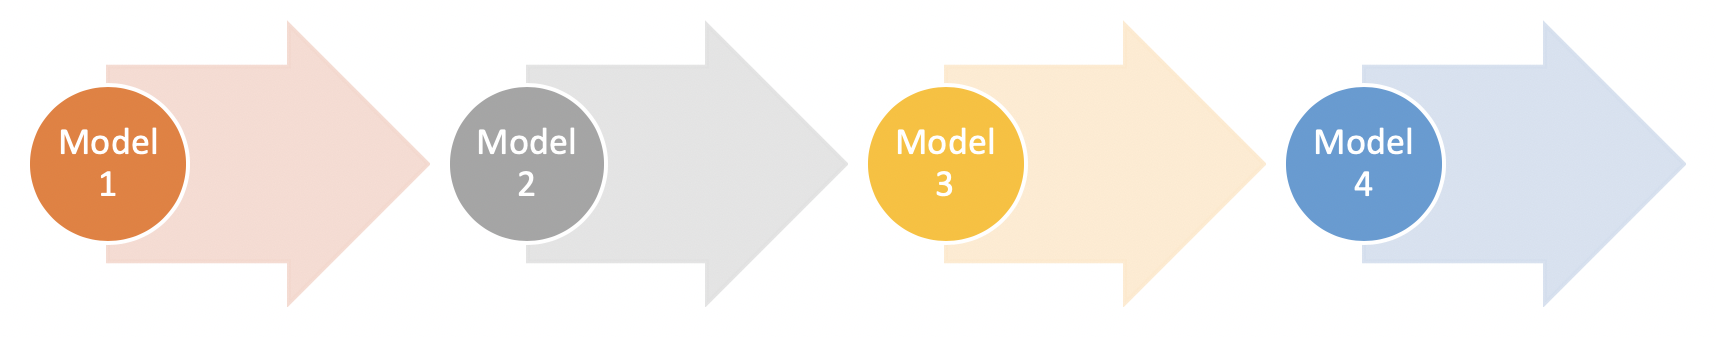

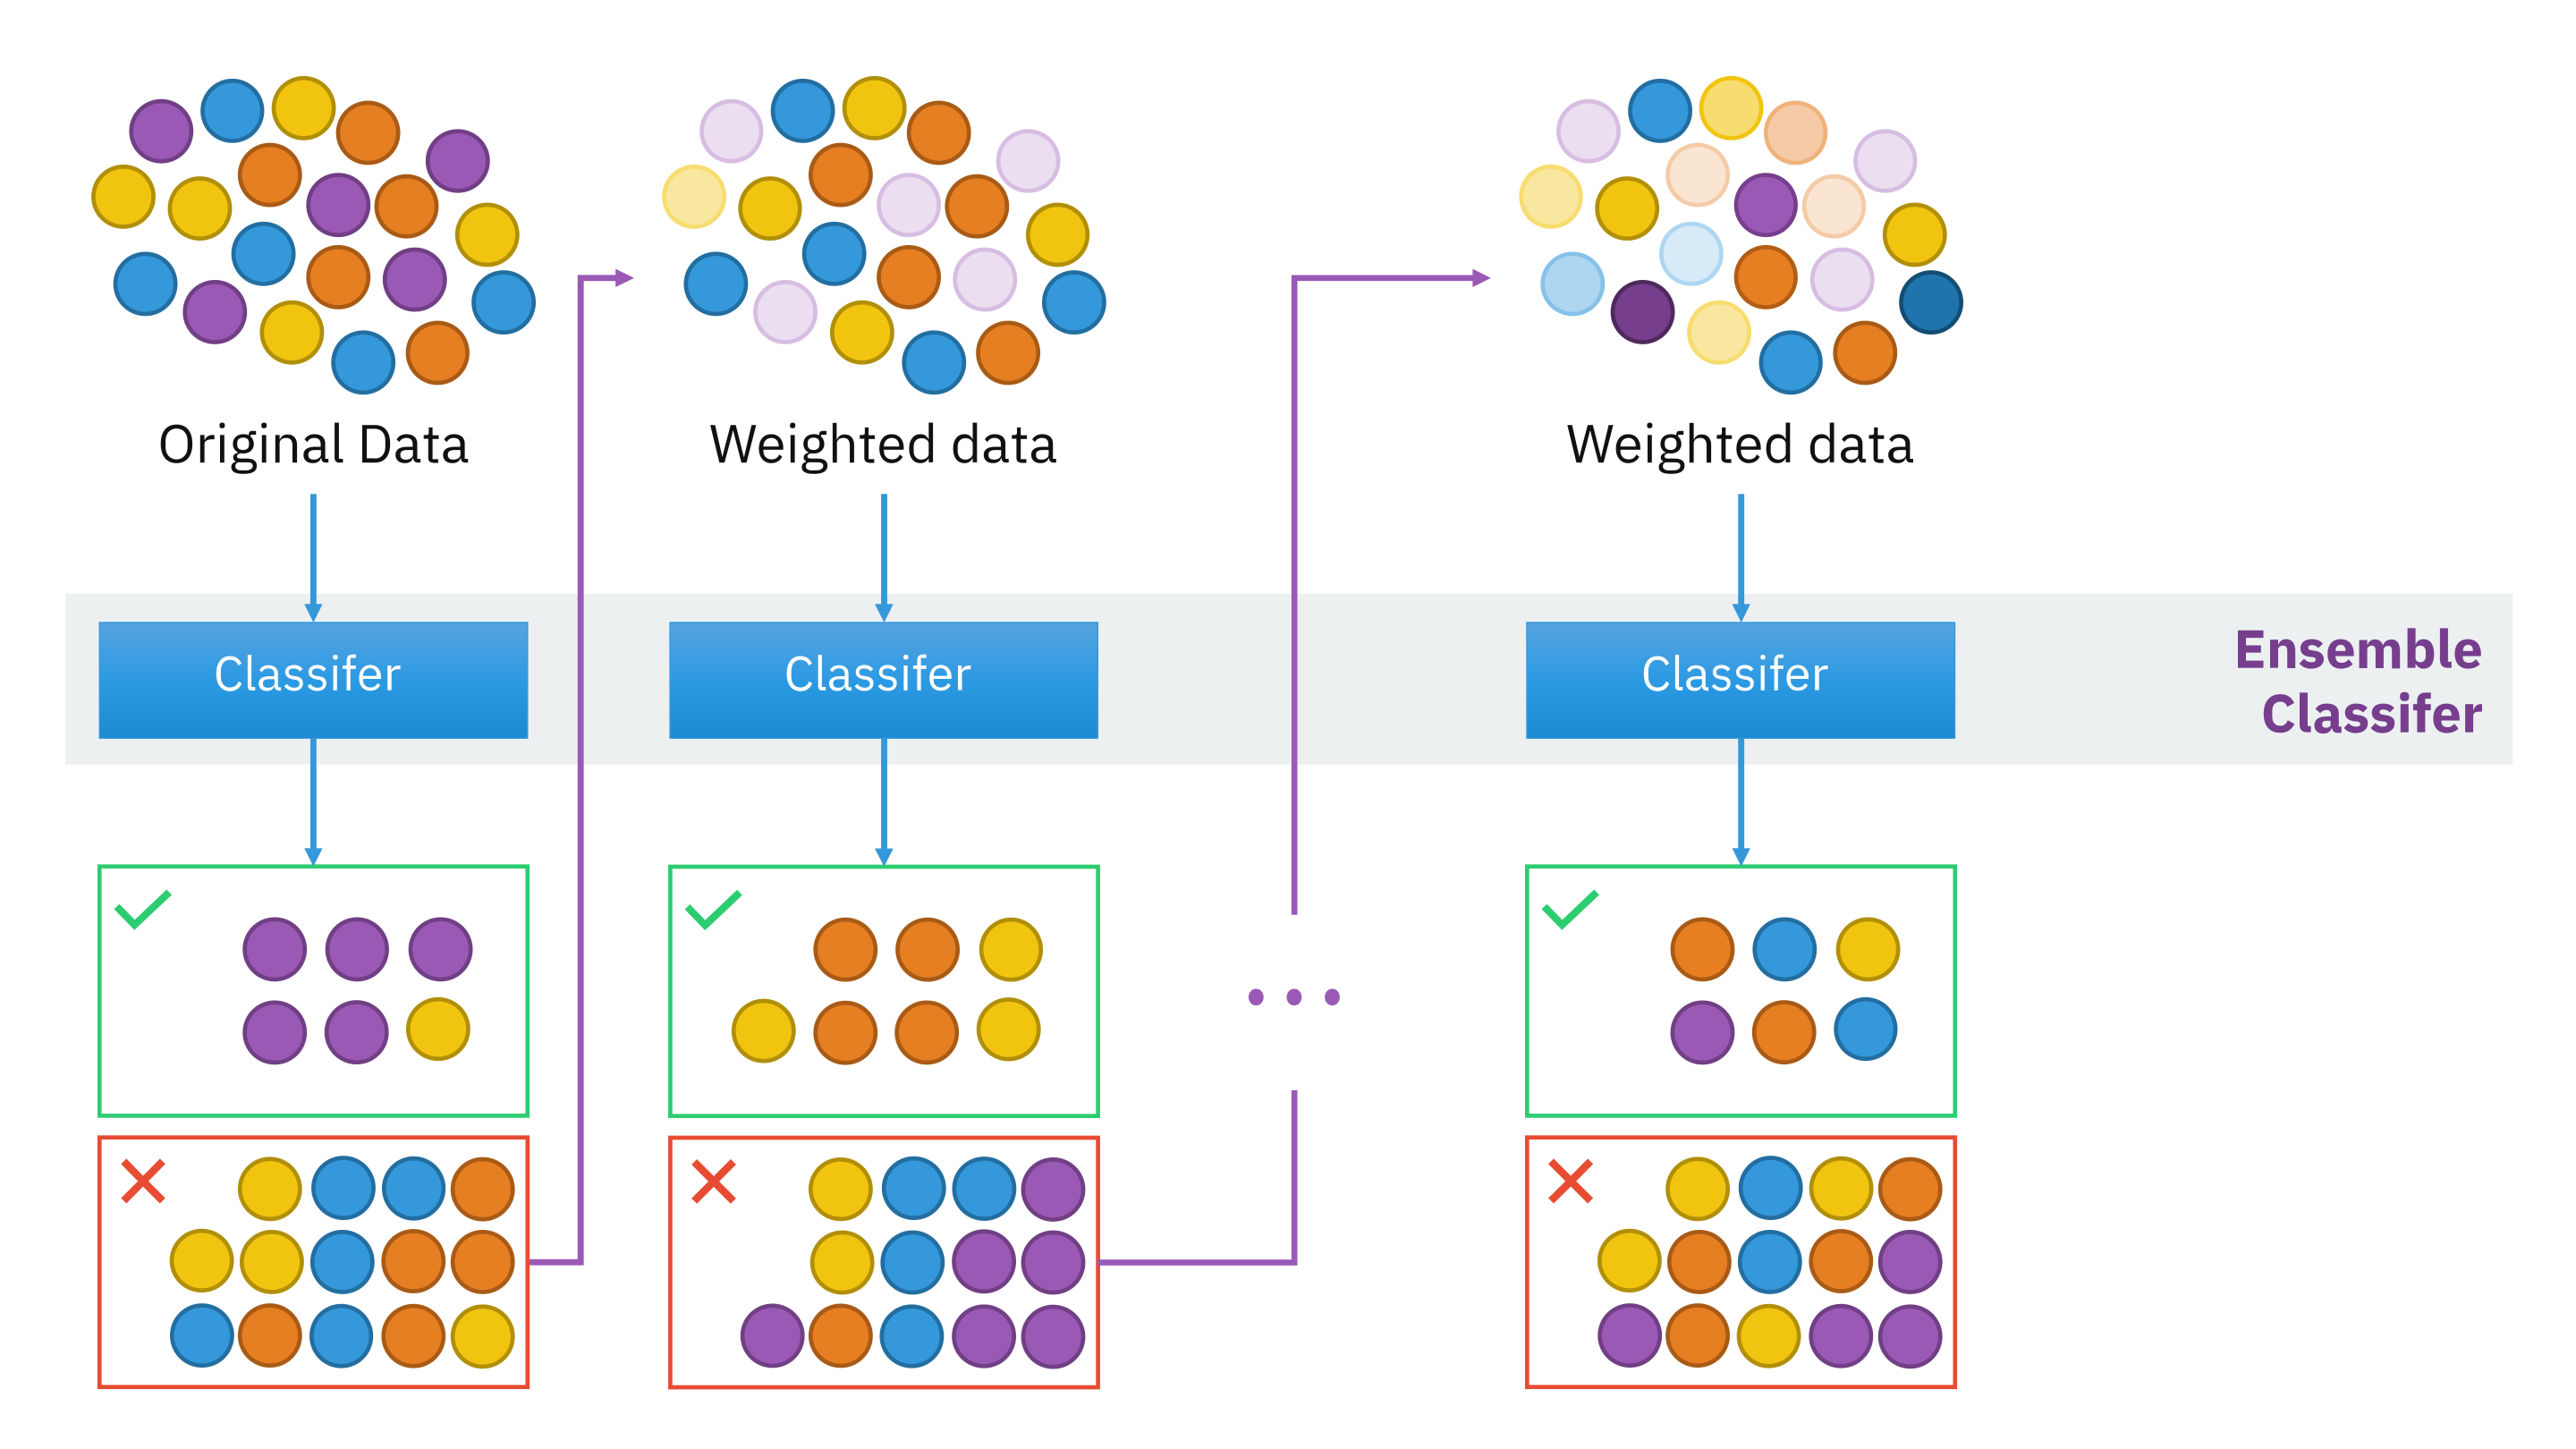

[[2](https://en.wikipedia.org/wiki/File:Ensemble_Boosting.svg)]

# AdaBoost

The core principle of AdaBoost (from `sklearn.ensemble`) is to fit a sequence of weak learners
(i.e., models that are only slightly better than random guessing, such
as small decision trees) on repeatedly modified versions of the data.
The predictions from all of them are then combined through a weighted
majority vote (or sum) to produce the final prediction. The data
modifications at each so-called boosting iteration consist of applying
weights $w_1$, $w_2$, \..., $w_N$ to each of the training samples.
Initially, those weights are all set to $w_i = 1/N$, so that the first
step simply trains a weak learner on the original data. For each
successive iteration, the sample weights are individually modified and
the learning algorithm is reapplied to the reweighted data. At a given
step, those training examples that were incorrectly predicted by the
boosted model induced at the previous step have their weights increased,
whereas the weights are decreased for those that were predicted
correctly. As iterations proceed, examples that are difficult to predict
receive ever-increasing influence. Each subsequent weak learner is
thereby forced to concentrate on the examples that are missed by the
previous ones in the sequence 

AdaBoost can be used both for classification and regression problems:

> -   For multi-class classification,
>     `AdaBoostClassifier` implements.
>     AdaBoost-SAMME and AdaBoost-SAMME.R.
> -   For regression, `AdaBoostRegressor` implements AdaBoost.R2.


The following example shows how to fit an AdaBoost classifier with 100
weak learners:

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9466666666666665

The number of weak learners is controlled by the parameter
`n_estimators`. The `learning_rate` parameter controls the contribution
of the weak learners in the final combination. By default, weak learners
are decision stumps. Different weak learners can be specified through
the `base_estimator` parameter. The main parameters to tune to obtain
good results are `n_estimators` and the complexity of the base
estimators (e.g., its depth `max_depth` or minimum required number of
samples to consider a split `min_samples_split`).

# Gradient Tree Boosting

[Gradient Tree
Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) or Gradient
Boosted Decision Trees (GBDT) is a generalization of boosting to
arbitrary differentiable loss functions. GBDT is an accurate and
effective off-the-shelf procedure that can be used for both regression
and classification problems in a variety of areas including Web search
ranking and ecology.

The module `sklearn.ensemble` provides
methods for both classification and regression via gradient boosted
decision trees.

Scikit-learn 0.21 introduces two new experimental implementations of
gradient boosting trees, namely
`HistGradientBoostingClassifier` and
`HistGradientBoostingRegressor`,
inspired by [LightGBM](https://github.com/Microsoft/LightGBM)

These histogram-based estimators can be **orders of magnitude faster**
than `GradientBoostingClassifier` and
`GradientBoostingRegressor` when the
number of samples is larger than tens of thousands of samples.

They also have built-in support for missing values, which avoids the
need for an imputer.

These estimators are described in more detail below in
`histogram_based_gradient_boosting`.

The following guide focuses on
`GradientBoostingClassifier` and
`GradientBoostingRegressor`, which might
be preferred for small sample sizes since binning may lead to split
points that are too approximate in this setting.

The usage and the parameters of
`GradientBoostingClassifier` and
`GradientBoostingRegressor` are
described below. The 2 most important parameters of these estimators are
`n_estimators` and `learning_rate`.

## Classification

`GradientBoostingClassifier` supports
both binary and multi-class classification. The following example shows
how to fit a gradient boosting classifier with 100 decision stumps as
weak learners:

In [8]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.913

The number of weak learners (i.e. regression trees) is controlled by the
parameter `n_estimators`; `The size of each tree` can be
controlled either by setting the tree depth via `max_depth` or by
setting the number of leaf nodes via `max_leaf_nodes`. The
`learning_rate` is a hyper-parameter in the range (0.0, 1.0\] that
controls overfitting via `shrinkage`.

## Regression

`GradientBoostingRegressor` supports a
number of
`different loss functions` for regression which can be specified via the argument
`loss`; the default loss function for regression is least squares
(`'ls'`).


In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

X, y = make_friedman1(n_samples=1200, random_state=0, noise=1.0)
X_train, X_test = X[:200], X[200:]
y_train, y_test = y[:200], y[200:]
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=1, random_state=0, loss='ls').fit(X_train, y_train)
mean_squared_error(y_test, est.predict(X_test))

5.009154859960319

The figure below shows the results of applying
`GradientBoostingRegressor` with least
squares loss and 500 base learners to the Boston house price dataset
(`sklearn.datasets.load_boston`). The
plot on the left shows the train and test error at each iteration. The
train error at each iteration is stored in the
`~GradientBoostingRegressor.train_score_`
attribute of the gradient boosting model. The test error at each
iterations can be obtained via the
`~GradientBoostingRegressor.staged_predict` method which returns a generator that yields the
predictions at each stage. Plots like these can be used to determine the
optimal number of trees (i.e. `n_estimators`) by early stopping. The
plot on the right shows the impurity-based feature importances which can
be obtained via the `feature_importances_` property.

MSE: 6.5941


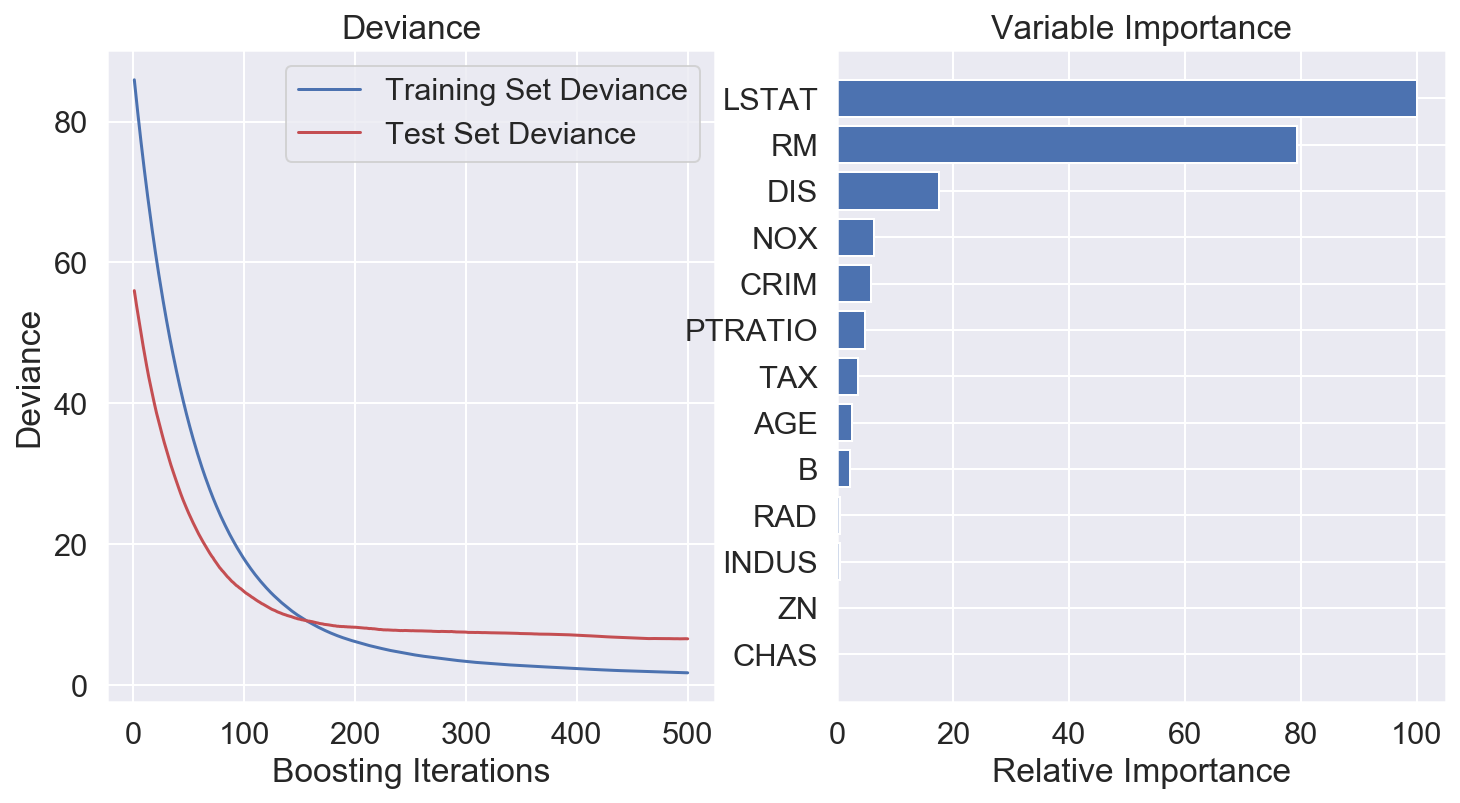

In [10]:
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Mathematical formulation
------------------------

We first present GBRT for regression, and then detail the classification
case.

### Regression

GBRT regressors are additive models whose prediction $y_i$ for a given
input $x_i$ is of the following form:

> $$\hat{y_i} = F_M(x_i) = \sum_{m=1}^{M} h_m(x_i)$$

where the $h_m$ are estimators called *weak learners* in the context of
boosting. Gradient Tree Boosting uses `decision tree regressors` of fixed size as weak learners.
The constant M corresponds to the `n_estimators` parameter.

Similar to other boosting algorithms, a GBRT is built in a greedy
fashion:

> $$F_m(x) = F_{m-1}(x) + h_m(x),$$

where the newly added tree $h_m$ is fitted in order to minimize a sum of
losses $L_m$, given the previous ensemble $F_{m-1}$:

> $$h_m =  \arg\min_{h} L_m = \arg\min_{h} \sum_{i=1}^{n}
> l(y_i, F_{m-1}(x_i) + h(x_i)),$$

where $l(y_i, F(x_i))$ is defined by the `loss` parameter,
detailed in the next section.

By default, the initial model $F_{0}$ is chosen as the constant that
minimizes the loss: for a least-squares loss, this is the empirical mean
of the target values. The initial model can also be specified via the
`init` argument.

Using a first-order Taylor approximation, the value of $l$ can be
approximated as follows:

> $$l(y_i, F_{m-1}(x_i) + h_m(x_i)) \approx
> l(y_i, F_{m-1}(x_i))
> + h_m(x_i)
> \left[ \frac{\partial l(y_i, F(x_i))}{\partial F(x_i)} \right]_{F=F_{m - 1}}.$$

Briefly, a first-order Taylor approximation says that
$l(z) \approx l(a) + (z - a) \frac{\partial l(a)}{\partial a}$. Here,
$z$ corresponds to $F_{m - 1}(x_i) + h_m(x_i)$, and $a$ corresponds to
$F_{m-1}(x_i)$

The quantity $\left[ \frac{\partial l(y_i, F(x_i))}{\partial F(x_i)}
\right]_{F=F_{m - 1}}$ is the derivative of the loss with respect to its
second parameter, evaluated at $F_{m-1}(x)$. It is easy to compute for
any given $F_{m - 1}(x_i)$ in a closed form since the loss is
differentiable. We will denote it by $g_i$.

Removing the constant terms, we have:

> $$h_m \approx \arg\min_{h} \sum_{i=1}^{n} h(x_i) g_i$$

This is minimized if $h(x_i)$ is fitted to predict a value that is
proportional to the negative gradient $-g_i$. Therefore, at each
iteration, **the estimator** $h_m$ **is fitted to predict the negative
gradients of the samples**. The gradients are updated at each
iteration. This can be considered as some kind of gradient descent in a
functional space.


For some losses, e.g. the least absolute deviation (LAD) where the
gradients are $\pm 1$, the values predicted by a fitted $h_m$ are not
accurate enough: the tree can only output integer values. As a result,
the leaves values of the tree $h_m$ are modified once the tree is
fitted, such that the leaves values minimize the loss $L_m$. The update
is loss-dependent: for the LAD loss, the value of a leaf is updated to
the median of the samples in that leaf.

### Classification

Gradient boosting for classification is very similar to the regression
case. However, the sum of the trees $F_M(x_i) = \sum_m h_m(x_i)$ is not
homogeneous to a prediction: it cannot be a class, since the trees
predict continuous values.

The mapping from the value $F_M(x_i)$ to a class or a probability is
loss-dependent. For the deviance (or log-loss), the probability that
$x_i$ belongs to the positive class is modeled as $p(y_i = 1 |
x_i) = \sigma(F_M(x_i))$ where $\sigma$ is the sigmoid function.

For multiclass classification, K trees (for K classes) are built at each
of the $M$ iterations. The probability that $x_i$ belongs to class k is
modeled as a softmax of the $F_{M,k}(x_i)$ values.

Note that even for a classification task, the $h_m$ sub-estimator is
still a regressor, not a classifier. This is because the sub-estimators
are trained to predict (negative) *gradients*, which are always
continuous quantities.

### Loss Functions

The following loss functions are supported and can be specified using
the parameter `loss`:

> -   Regression
>     -   Least squares (`'ls'`): The natural choice for regression due
>         to its superior computational properties. The initial model is
>         given by the mean of the target values.
>     -   Least absolute deviation (`'lad'`): A robust loss function for
>         regression. The initial model is given by the median of the
>         target values.
>     -   Huber (`'huber'`): Another robust loss function that combines
>         least squares and least absolute deviation; use `alpha` to
>         control the sensitivity with regards to outliers.
>     -   Quantile (`'quantile'`): A loss function for quantile
>         regression. Use `0 < alpha < 1` to specify the quantile. This
>         loss function can be used to create prediction intervals.
> -   Classification
>     -   Binomial deviance (`'deviance'`): The negative binomial
>         log-likelihood loss function for binary classification
>         (provides probability estimates). The initial model is given
>         by the log odds-ratio.
>     -   Multinomial deviance (`'deviance'`): The negative multinomial
>         log-likelihood loss function for multi-class classification
>         with `n_classes` mutually exclusive classes. It provides
>         probability estimates. The initial model is given by the prior
>         probability of each class. At each iteration `n_classes`
>         regression trees have to be constructed which makes GBRT
>         rather inefficient for data sets with a large number of
>         classes.
>     -   Exponential loss (`'exponential'`): The same loss function as
>         `AdaBoostClassifier`. Less
>         robust to mislabeled examples than `'deviance'`; can only be
>         used for binary classification.

### Shrinkage via learning rate

Consider a simple regularization strategy that scales the
contribution of each weak learner by a constant factor $\nu$:

$$F_m(x) = F_{m-1}(x) + \nu h_m(x)$$

The parameter $\nu$ is also called the **learning rate** because it
scales the step length the gradient descent procedure; it can be set via
the `learning_rate` parameter.

The parameter `learning_rate` strongly interacts with the parameter
`n_estimators`, the number of weak learners to fit. Smaller values of
`learning_rate` require larger numbers of weak learners to maintain a
constant training error. Empirical evidence suggests that small values
of `learning_rate` favor better test error. Recommended to set
the learning rate to a small constant (e.g. `learning_rate <= 0.1`) and
choose `n_estimators` by early stopping.

### Subsampling

Consider stochastic gradient boosting, which combines
gradient boosting with bootstrap averaging (bagging). At each iteration
the base classifier is trained on a fraction `subsample` of the
available training data. The subsample is drawn without replacement. A
typical value of `subsample` is 0.5.

The figure below illustrates the effect of shrinkage and subsampling on
the goodness-of-fit of the model. We can clearly see that shrinkage
outperforms no-shrinkage. Subsampling with shrinkage can further
increase the accuracy of the model. Subsampling without shrinkage, on
the other hand, does poorly.

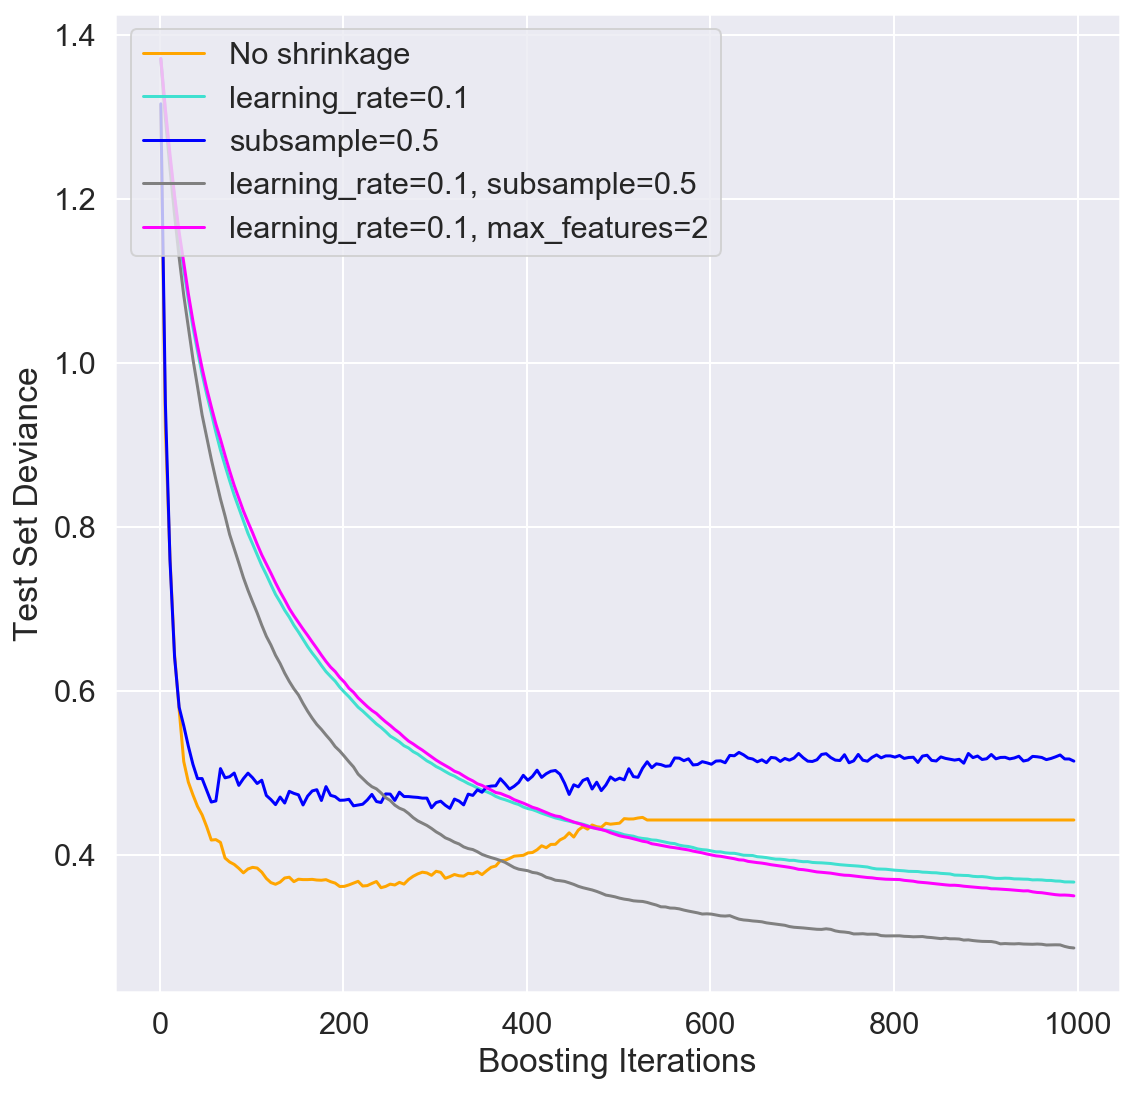

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets


X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
X = X.astype(np.float32)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}

plt.figure()

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()

Another strategy to reduce the variance is by subsampling the features
analogous to the random splits in
`RandomForestClassifier`. The number of
subsampled features can be controlled via the `max_features` parameter.

Using a small `max_features` value can significantly decrease the
runtime.

Stochastic gradient boosting allows to compute out-of-bag estimates of
the test deviance by computing the improvement in deviance on the
examples that are not included in the bootstrap sample (i.e. the
out-of-bag examples). The improvements are stored in the attribute
`~GradientBoostingRegressor.oob_improvement_`. `oob_improvement_[i]` holds the improvement in terms of
the loss on the OOB samples if you add the i-th stage to the current
predictions. Out-of-bag estimates can be used for model selection, for
example to determine the optimal number of iterations. OOB estimates are
usually very pessimistic thus we recommend to use cross-validation
instead and only use OOB if cross-validation is too time consuming.


## Interpretation with feature importance


Individual decision trees can be interpreted easily by simply
visualizing the tree structure. Gradient boosting models, however,
comprise hundreds of regression trees thus they cannot be easily
interpreted by visual inspection of the individual trees. Fortunately, a
number of techniques have been proposed to summarize and interpret
gradient boosting models.

Often features do not contribute equally to predict the target response;
in many situations the majority of the features are in fact irrelevant.
When interpreting a model, the first question usually is: what are those
important features and how do they contributing in predicting the target
response?

Individual decision trees intrinsically perform feature selection by
selecting appropriate split points. This information can be used to
measure the importance of each feature; the basic idea is: the more
often a feature is used in the split points of a tree the more important
that feature is. This notion of importance can be extended to decision
tree ensembles by simply averaging the impurity-based feature importance
of each tree (see `random_forest_feature_importance` for more details).

The feature importance scores of a fit gradient boosting model can be
accessed via the `feature_importances_` property:

In [12]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_hastie_10_2(random_state=0)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X, y)
clf.feature_importances_

array([0.10684213, 0.10461707, 0.11265447, 0.09863589, 0.09469133,
       0.10729306, 0.09163753, 0.09718194, 0.09581415, 0.09063242])

Note that this computation of feature importance is based on entropy,
and it is distinct from
`sklearn.inspection.permutation_importance` which is based on permutation of the features.

# Stacked generalization

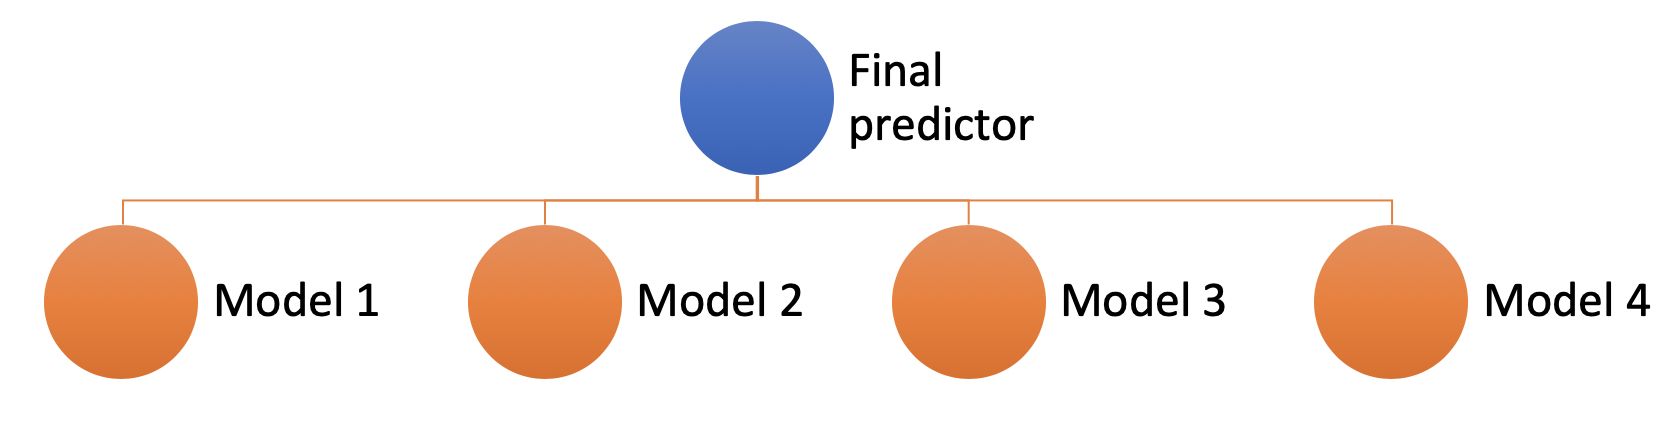

Stacked generalization is a method for combining estimators to reduce
their biases. More precisely, the predictions
of each individual estimator are stacked together and used as input to a
final estimator to compute the prediction. This final estimator is
trained through cross-validation.

The `StackingClassifier` and
`StackingRegressor` provide such
strategies which can be applied to classification and regression
problems.

The `estimators` parameter corresponds to the list of the
estimators which are stacked together in parallel on the input data. It
should be given as a list of names and estimators:

In [13]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.svm import SVR
estimators = [('ridge', RidgeCV()),
              ('lasso', LassoCV(random_state=42)),
              ('svr', SVR(C=1, gamma=1e-6))]

The `final_estimator` will use the predictions of the
`estimators` as input. It needs to be a classifier or a
regressor when using `StackingClassifier` or `StackingRegressor`,
respectively:

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(random_state=42))

To train the `estimators` and
`final_estimator`, the `fit` method needs to be
called on the training data:

In [15]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)
reg.fit(X_train, y_train)

StackingRegressor(cv=None,
                  estimators=[('ridge',
                               RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                       cv=None, fit_intercept=True,
                                       gcv_mode=None, normalize=False,
                                       scoring=None, store_cv_values=False)),
                              ('lasso',
                               LassoCV(alphas=None, copy_X=True, cv=None,
                                       eps=0.001, fit_intercept=True,
                                       max_iter=1000, n_alphas=100, n_jobs=None,
                                       normalize=False, positive=False,
                                       precompute='auto', random_s...
                                                            max_depth=3,
                                                            max_features=None,
                                                            max_leaf_nodes=None,
   

During training, the `estimators` are fitted on the whole
training data `X_train`. They will be used when calling
`predict` or `predict_proba`. To generalize and
avoid over-fitting, the `final_estimator` is trained on
out-samples using
`sklearn.model_selection.cross_val_predict` internally.

For `StackingClassifier`, note that the
output of the `estimators` is controlled by the parameter
`stack_method` and it is called by each estimator. This
parameter is either a string, being estimator method names, or
'auto' which will automatically identify an available
method depending on the availability, tested in the order of preference:
`predict_proba`, `decision_function` and
`predict`.

A `StackingRegressor` and
`StackingClassifier` can be used as any
other regressor or classifier, exposing a `predict`,
`predict_proba`, and `decision_function`
methods, e.g.:

In [16]:
y_pred = reg.predict(X_test)
from sklearn.metrics import r2_score
print('R2 score: {:.2f}'.format(r2_score(y_test, y_pred)))

R2 score: 0.81


Note that it is also possible to get the output of the stacked outputs
of the `estimators` using the `transform`
method:

In [17]:
reg.transform(X_test[:5])

array([[28.78639592, 28.433658  , 22.62294373],
       [35.96334643, 32.58788457, 23.68491013],
       [14.97187105, 14.05965525, 16.45282443],
       [25.1991887 , 25.54000515, 22.92830073],
       [18.93352588, 19.26508705, 17.0351469 ]])

In practise, a stacking predictor predict as good as the best predictor of the base layer and even sometimes outputperform it by combining the different strength of the these predictors. However, training a stacking predictor is computationally expensive.
[[2](https://scikit-learn.org/stable/modules/ensemble.html)]